In [1]:
import gzip
import math
import statistics as stats
import random
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn import linear_model
import json
import regex as re

In [2]:
df = pd.read_json('Video_Games.json.gz', lines=True)

In [3]:
df[:5]

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1,True,"06 9, 2014",A21ROB4YDOZA5P,0439381673,Mary M. Clark,I used to play this game years ago and loved i...,Did not like this,1402272000,NaN,NaN,NaN
1,3,True,"05 10, 2014",A3TNZ2Q5E7HTHD,0439381673,Sarabatya,The game itself worked great but the story lin...,Almost Perfect,1399680000,NaN,NaN,NaN
2,4,True,"02 7, 2014",A1OKRM3QFEATQO,0439381673,Amazon Customer,I had to learn the hard way after ordering thi...,DOES NOT WORK WITH MAC OS unless it is 10.3 or...,1391731200,15,NaN,NaN
3,1,True,"02 7, 2014",A2XO1JFCNEYV3T,0439381673,ColoradoPartyof5,The product description should state this clea...,does not work on Mac OSX,1391731200,11,NaN,NaN
4,4,True,"01 16, 2014",A19WLPIRHD15TH,0439381673,Karen Robinson,I would recommend this learning game for anyon...,Roughing it,1389830400,NaN,NaN,NaN


## 1. EDA

In [4]:
data = df.sample(n = 400000)
data[:5]

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
2490030,1,True,"09 29, 2015",AO9HWHM7Y0GCS,B00JH15U94,todd,They don't stick very well,One Star,1443484800,NaN,NaN,NaN
184246,4,True,"09 29, 2014",A159AFUV50MWAI,B00012D0SG,ratboyhawaii,Works great,Four Stars,1411948800,NaN,NaN,NaN
1224528,5,True,"11 21, 2015",A1QK90OHMNVT6N,B00BMFIXOW,R. Williams,great game,Five Stars,1448064000,NaN,{'Format:': ' Video Game'},NaN
1626263,1,False,"11 20, 2014",AYSEMCJTEQ4ZP,B00KWEHBAG,J. James,Link has stolen moves from Ryu Hayabusa in Nin...,Repetitive Garbage +,1416441600,9,"{'Edition:': ' Standard', 'Platform:': ' Ninte...",NaN
1305278,5,True,"04 27, 2015",A2ALW0B94KA91N,B00D6PTMSW,Emily Hinds,This is a great product. I've learned a lot so...,Five Stars,1430092800,NaN,"{'Edition:': ' Cable Included', 'Platform:': '...",NaN


**------------This needs to be cited-------------** <br>
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

The dataset we have chosen to work with are video game reviews on Amazon from 2014. There are 2,565,349 reviews in total, however for the purpose of computation, we have sampled 100,000 reviews. The data consists of 12 features: overall rating, verified (binary), time of review (raw), reviewer ID, product ID, name of reviewer, text of review, summary of product, time of review (unix), helpfulness votes (likes), product style, and attached image. 

Lets take a look at the data type for each column, and how many non-null values there are. 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 482656 to 1219064
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         400000 non-null  int64 
 1   verified        400000 non-null  bool  
 2   reviewTime      400000 non-null  object
 3   reviewerID      400000 non-null  object
 4   asin            400000 non-null  object
 5   reviewerName    399953 non-null  object
 6   reviewText      399738 non-null  object
 7   summary         399860 non-null  object
 8   unixReviewTime  400000 non-null  int64 
 9   vote            69287 non-null   object
 10  style           206115 non-null  object
 11  image           4398 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 37.0+ MB


Lets add some features, like length of review text and length of summary, and replace NAN values with 0 for votes to perform some basic statistics.

In [5]:
#data = data[['overall', 'reviewTime', 'reviewText', 'summary', 'unixReviewTime', 'vote']]
data['vote'] = data['vote'].replace(np.nan, 0).str.replace(',', '').astype(float)
data['reviewText'] = data['reviewText'].replace(np.nan, '')
data['summary'] = data['summary'].replace(np.nan, '')
data['verified'] = data['verified'].replace({True: 1, False: 0})

data['len_reviewText'] = [len(x) for x in data['reviewText']]
data['len_summary'] = [len(x) for x in data['summary']]

In [7]:
data[['overall', 'vote', 'len_reviewText', 'len_summary']].describe()

,overall,vote,len_reviewText,len_summary
count,400000.000000,69287.000000,400000.000000,400000.000000
mean,4.018607,8.394215,402.170152,23.432140
std,1.407491,27.875560,814.643470,18.758995
min,1.000000,2.000000,0.000000,0.000000
25%,3.000000,2.000000,55.000000,10.000000
50%,5.000000,4.000000,152.000000,16.000000
75%,5.000000,7.000000,398.000000,31.000000
max,5.000000,3005.000000,32554.000000,282.000000


In [12]:
#Histogram on months, extract months for each review and bar plot count per months**
#overall by months
#Bivariative: 

In [36]:
over = [d for d in data['overall']]
lengths = [len(d) for d in data['reviewText']]

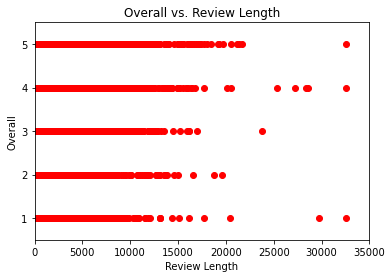

In [47]:
import matplotlib.pyplot as plt
plt.scatter(lengths, over, color='red')
plt.xlim(0, 35000)
plt.ylim(0.5, 5.5)
plt.xlabel("Review Length")
plt.ylabel("Overall")
plt.title("Overall vs. Review Length")
plt.show()

overall rating by length of review text, 

In [64]:
v = data.groupby(['verified', 'overall']).count()
v

reviewTime  reviewerID    asin  reviewerName  reviewText  \
verified overall                                                             
0        1             14925       14925   14925         14923       14925   
         2              7139        7139    7139          7138        7139   
         3              9647        9647    9647          9645        9647   
         4             18845       18845   18845         18843       18845   
         5             45772       45772   45772         45766       45772   
1        1             33971       33971   33971         33968       33971   
         2             14854       14854   14854         14852       14854   
         3             23551       23551   23551         23547       23551   
         4             45753       45753   45753         45747       45753   
         5            185543      185543  185543        185524      185543   

                  summary  unixReviewTime   vote  style  image  \
verified overall                                                 
0        1          14925           14925   8274   8438    114   
         2           7139            7139   3453   4021     52   
         3           9647            9647   3975   5104     55   
         4          18845           18845   7039   9703    180   
         5          45772           45772  15167  24025    506   
1        1          33971           33971   7515  14905    686   
         2          14854           14854   2463   7011    212   
         3          23551           23551   3055  11588    242   
         4          45753           45753   4552  23452    495   
         5         185543          185543  13794  97868   1856   

                  len_reviewText  len_summary  
verified overall                               
0        1                 14925        14925  
         2                  7139         7139  
         3                  9647         9647  
         4                 18845        18845  
         5                 45772        45772  
1        1                 33971        33971  
         2                 14854        14854  
         3                 23551        23551  
         4                 45753        45753  
         5                185543       185543

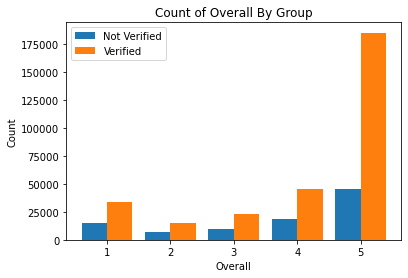

In [66]:
veri_not = [14925, 7139, 9647, 18845, 45772]
veri = [33971, 14854, 23551, 45753, 185543]

X_axis = np.arange(5)

plt.bar(X_axis - 0.2, veri_not, 0.4, label = 'Not Verified')
plt.bar(X_axis + 0.2, veri, 0.4, label = 'Verified')
  
plt.xticks(X_axis, [1, 2, 3, 4, 5])
plt.xlabel("Overall")
plt.ylabel("Count")
plt.title("Count of Overall By Group")
plt.legend()
plt.show()

In [68]:
m = data.groupby('verified')['overall'].mean()
m

verified
0    3.761980
1    4.100013
Name: overall, dtype: float64

In [6]:
data['year']  = data['reviewTime'].str[-4:]
data['month'] = data['reviewTime'].str[:2]

In [7]:
t = data.groupby(['month', 'year'])[['overall']].mean()
t = t.reset_index().pivot('month', 'year')

In [8]:
t

overall                                                         \
year     1997 1998      1999      2000      2001      2002      2003   
month                                                                  
01        NaN  1.0       NaN  3.897059  3.821256  4.126609  3.992611   
02        NaN  NaN       NaN  3.793651  3.928177  4.011050  4.162162   
03        NaN  NaN       NaN  3.969231  4.005319  3.928977  4.087855   
04        NaN  5.0       NaN  4.122807  4.157635  4.110778  4.063014   
05        NaN  NaN       NaN  3.824176  3.959821  4.046693  4.054795   
06        NaN  NaN       NaN  4.108911  4.043165  4.104520  3.996875   
07        NaN  NaN       NaN  3.957143  4.117647  4.066832  4.066890   
08        NaN  NaN       NaN  4.042553  4.195312  4.130573  4.046693   
09        NaN  NaN  5.000000  4.340580  3.896396  4.107937  4.000000   
10        NaN  NaN       NaN  4.157360  4.202985  3.970350  4.037671   
11        5.0  NaN  4.000000  3.984127  4.070312  3.979911  4.057065   
12        NaN  NaN  4.081633  3.942085  4.089054  3.932489  3.932136   

                                     ...                                \
year       2004      2005      2006  ...      2009      2010      2011   
month                                ...                                 
01     3.975124  3.752688  3.759563  ...  3.961478  3.868147  3.891358   
02     4.036900  3.932432  3.931159  ...  3.992241  3.993641  3.814202   
03     3.944954  3.889908  3.788804  ...  3.910318  3.866285  3.849008   
04     3.958333  3.660436  3.736059  ...  3.870833  3.924552  3.932990   
05     3.933054  3.576923  3.892241  ...  3.961816  3.923928  3.785714   
06     3.854962  3.789272  3.593443  ...  3.833984  3.965217  3.808965   
07     3.915094  3.891304  3.768489  ...  3.870321  3.765079  3.887309   
08     3.866667  3.963077  3.877814  ...  3.836707  3.822454  3.952794   
09     3.810631  3.924837  3.669856  ...  3.961332  3.743142  3.961977   
10     3.946372  3.739812  3.373984  ...  3.943337  3.689252  3.881038   
11     3.960265  3.569444  3.908120  ...  3.844881  3.677800  3.703540   
12     3.886139  3.620614  3.502451  ...  3.854118  3.868560  3.874514   

                                                                             
year       2012      2013      2014      2015      2016      2017      2018  
month                                                                        
01     3.928967  4.177555  4.114046  4.247040  4.125016  4.156006  3.940942  
02     3.958873  4.073587  4.023967  4.167676  4.082312  4.044256  3.879121  
03     3.741935  3.810172  3.994895  4.167320  4.117994  4.044109  3.941562  
04     3.857762  4.067255  4.048237  4.142832  4.058732  3.968574  3.944828  
05     3.421555  4.080645  4.034635  4.116215  4.133542  3.981341  3.811494  
06     3.505627  4.012371  3.992408  4.125846  4.104936  3.948544  3.853472  
07     3.660757  4.070262  4.194082  4.122782  4.085633  3.951000  3.921510  
08     3.809264  4.016973  4.170927  4.160400  4.046312  3.994428  3.988095  
09     3.806133  3.999585  4.072910  4.102984  3.994790  3.931546  3.986813  
10     3.939698  4.025243  4.158248  4.083168  4.006572  3.841054  5.000000  
11     3.987391  3.916063  4.112546  4.040073  3.994565  3.895444       NaN  
12     4.129062  3.982143  4.187653  3.963480  4.084405  3.810238       NaN  

[12 rows x 22 columns]

Text(0.5, 1.0, 'Mean Overall Rating by Month and Year')

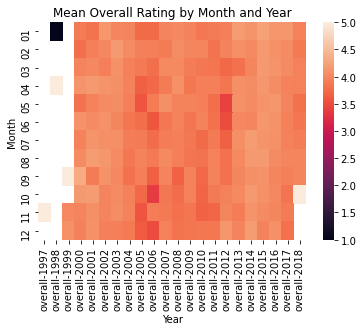

In [10]:
import seaborn as sb
import matplotlib.pyplot as plt

sb.heatmap(t)
plt.xlabel('Year')
#plt.xticks([1997, 1999, 2000,2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
plt.ylabel('Month')
plt.title('Mean Overall Rating by Month and Year')

In [18]:
test_data = df.sample(n = 100000)

test_data['vote'] = test_data['vote'].replace(np.nan, 0).str.replace(',', '').astype(float)
test_data['reviewText'] = test_data['reviewText'].replace(np.nan, '')
test_data['summary'] = test_data['summary'].replace(np.nan, '')
test_data['verified'] = test_data['verified'].replace({True: 1, False: 0})

## 2. Predictive Task (Baseline)

In [19]:
wordCount = defaultdict(int)
for d in data['reviewText']:
    for w in re.sub(r'[^\w\s]',' ', d.lower()).split():
        #w = stemmer.stem(w)
        wordCount[w] += 1

In [20]:
most_common = sorted(wordCount.items(), key=lambda x:x[1], reverse = True)
most_common[:10]

[('the', 1592823),
 ('and', 825209),
 ('i', 785492),
 ('to', 772455),
 ('a', 742084),
 ('it', 708001),
 ('is', 518320),
 ('of', 512010),
 ('you', 471519),
 ('game', 465998)]

In [21]:
words = [w[0] for w in most_common[:1000]]
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [22]:
def feature(datum):
    feat = [0]*len(wordSet)
    words = re.sub(r'[^\w\s]',' ', datum.lower()).split()
    for w in words:
        if not (w in wordSet): continue
        feat[wordId[w]] += 1
    #feat.append(1)
    return feat

In [23]:
X = [feature(d) for d in data['reviewText']]
y = [d for d in data['overall']]

In [24]:
clf = linear_model.Ridge(1.0, fit_intercept=True) # MSE + 1.0 l2
clf.fit(X, y)
theta = clf.coef_

In [25]:
test_x = [feature(d) for d in test_data['reviewText']]
test_y = [d for d in test_data['overall']]
predictions = clf.predict(test_x)

In [26]:
mse = []
for overall, pred in zip(test_y, predictions):
    mse.append((overall - pred)**2)

sum(mse) / len(mse)

1.3261247424574198

In [22]:
#1.31971075
#1.3025469
#1.3220734588625265
#1.3076679295996954

## 3. Model (Fine Tuning, N-grams, Adding features)

In [23]:
for s in [1500, 2000, 2500, 3000]:
    words = [w[0] for w in most_common[:s]]
    wordId = dict(zip(words, range(len(words))))
    wordSet = set(words)
    X = [feature(d) for d in data['reviewText']]
    y = [d for d in data['overall']]
    clf = linear_model.Ridge(1.0, fit_intercept=True) # MSE + 1.0 l2
    clf.fit(X, y)
    theta = clf.coef_
    test_x = [feature(d) for d in test_data['reviewText']]
    test_y = [d for d in test_data['overall']]
    predictions = clf.predict(test_x)
    mse = []
    for overall, pred in zip(test_y, predictions):
        mse.append((overall - pred)**2)

    print((s, sum(mse) / len(mse)))

(1500, 1.2813933794872336)
(2000, 1.2662325705347206)
(2500, 1.254834037526296)


In [ ]:
#1500 dict size, 1.2813933794872336
#2000 dict size, 1.2662325705347206
#2500 dict size, 1.254834037526296

MSE goes down as dictionary size increases, however 3000 and 3500 is computationally expensive so we will probably go with 2500

In [18]:
for const in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    clf = linear_model.Ridge(const, fit_intercept=True)
    clf.fit(X, y)
    predictions = clf.predict(test_x)
    mse = []
    for overall, pred in zip(test_y, predictions):
        mse.append((overall - pred)**2)

    print((const, sum(mse) / len(mse)))

(0.001, 1.3161627640142177)
(0.01, 1.31616274255842)
(0.1, 1.316162528034182)
(1, 1.316160386137475)
(10, 1.3161393006174955)
(100, 1.3159607229360941)
(1000, 1.3165856425913705)


Best alpha was 100

In [19]:
clf = linear_model.LinearRegression(fit_intercept = True)
clf.fit(X, y)
theta = clf.coef_
predictions = clf.predict(test_x)
for overall, pred in zip(test_y, predictions):
    mse.append((overall - pred)**2)

print(sum(mse) / len(mse))

(1000, 1.316374204494766)


Tried linear regression instead of ridge, same results though

In [ ]:
#n-gram model

In [27]:
wordCount = defaultdict(int)
for d in data['reviewText']:
    r = re.sub(r'[^\w\s]',' ', d.lower())#.split()
    ws = r.split()
    ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
    ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
    ws4 = [' '.join(x) for x in list(zip(ws[:-3],ws[1:-2],ws[2:-1],ws[3:]))]
    ws5 = [' '.join(x) for x in list(zip(ws[:-4],ws[1:-3],ws[2:-2],ws[3:-1],ws[4:]))]
    for w in ws + ws2 + ws3 + ws4 + ws5:
        wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [28]:
words = [x[1] for x in counts[:3000]]
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [29]:
def feature_2(datum):
    feat = [0]*len(words)
    r = re.sub(r'[^\w\s]',' ', datum.lower())#.split()
    ws = r.split()
    ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
    ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
    ws4 = [' '.join(x) for x in list(zip(ws[:-3],ws[1:-2],ws[2:-1],ws[3:]))]
    ws5 = [' '.join(x) for x in list(zip(ws[:-4],ws[1:-3],ws[2:-2],ws[3:-1],ws[4:]))]
    for w in ws + ws2 + ws3 + ws4 + ws5:
        if w in words:
            feat[wordId[w]] += 1
    #feat.append(1) #offset
    return feat

In [32]:
X = [feature_2(d) for d in data['reviewText']]
y = [d for d in data['overall']]

In [33]:
clf = linear_model.LinearRegression(fit_intercept = True)
clf.fit(X, y)
theta = clf.coef_
test_x = [feature_2(d) for d in test_data['reviewText']]
test_y = [d for d in test_data['overall']]
predictions = clf.predict(test_x)

In [34]:
mse = []
for overall, pred in zip(test_y, predictions):
    mse.append((overall - pred)**2)

sum(mse) / len(mse)

1.215942703658607

In [35]:
#1.3491526594815273, 1000 dict size
#1.239766746598694 , 2000 dict size
#1.215942703658607, 3000 dict size

In [ ]:
#n-gram model + verified/not + one_hot(reviewTime) + length of reviewText

In [38]:
#Note to include in write up: We wanted to try to use votes as a feature but over 80% of the data was missing and
# and we replaced with 0 so it wouldve probably skewed our results

In [30]:
year = data['reviewTime'].str[-4:]
month = data['reviewTime'].str[:2]

test_year = test_data['reviewTime'].str[-4:]
test_month = test_data['reviewTime'].str[:2]

In [31]:
def feature_month(month):
    #original represents 12
    f = [0] * 11
    if month == '11':
        f = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    if month == '10':
        f = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
    if month == '09':
        f = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
    if month == '08':
        f = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
    if month == '07':
        f = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    if month == '06':
        f = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
    if month == '05':
        f = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    if month == '04':
        f = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
    if month == '03':
        f = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    if month == '02':
        f = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    if month == '01':
        f = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    return f

In [32]:
def feature_year(year):
    #original represents 2018
    f = [0] * 19
    if year == '2017': 
        f = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    if year == '2016':
        f = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
    if year == '2015':
        f = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
    if year == '2014':
        f = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
    if year == '2013':
        f = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    if year == '2012':
        f = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
    if year == '2011':
        f = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    if year == '2010':
        f = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
    if year == '2009':
        f = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    if year == '2008':
        f = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    if year == '2007':
        f = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    if year == '2006':
        f = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    if year == '2005':
        f = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    if year == '2004':
        f = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    if year == '2003':
        f = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    if year == '2002':
        f = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    if year == '2001':
        f = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    if year == '2000':
        f = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    if year == '1999':
        f = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    return f

In [33]:
X = [feature_2(a) + [len(a)] + feature_month(b) + feature_year(c) + [d] for a,b,c,d in zip(data['reviewText'], month, year, data['verified'])]
y = [d for d in data['overall']]

In [34]:
clf = linear_model.LinearRegression(fit_intercept = True)
clf.fit(X, y)
theta = clf.coef_
test_x = [feature_2(a) + [len(a)] + feature_month(b) + feature_year(c) + [d] for a,b,c,d in zip(test_data['reviewText'], test_month, test_year, test_data['verified'])]
test_y = [d for d in test_data['overall']]
predictions = clf.predict(test_x)

In [35]:
mse = []
for overall, pred in zip(test_y, predictions):
    mse.append((overall - pred)**2)

sum(mse) / len(mse)

1.1849757420133886

In [ ]:
#1.1849757420133886